# Text augmentation demo
- Backgrounds: rendered composites with text removed from `/home/ubuntu/jjseol/layer_data/inpainting_250k_subset_rendered`
- Layout JSON: `/home/ubuntu/jjseol/layer_data/inpainting_250k_subset`
- Fonts: `/home/ubuntu/fonts_top_1000` (prefer `.ttf`/`.otf`; fallback to default if needed)
- Output (if you ever save): `/home/ubuntu/augmented_samples` (currently preview-only)

Run the cells below in order to generate and preview sample images.


In [3]:
import json
import random
import textwrap
import statistics
from collections import Counter
from pathlib import Path
from typing import List, Tuple, Dict

try:
    from tqdm import tqdm
except ImportError:  # lightweight fallback
    tqdm = None

import wikipedia
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

# ----------------------------
# Paths
# ----------------------------
FONTS_DIR = Path("/home/ubuntu/fonts_top_1000").resolve()
OUTPUT_DIR = Path("/home/ubuntu/augmented_samples").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RENDERED_ROOT = Path("/home/ubuntu/jjseol/layer_data/inpainting_250k_subset_rendered").resolve()
JSON_ROOT = Path("/home/ubuntu/jjseol/layer_data/inpainting_250k_subset").resolve()
TEXT_LENGTH_CACHE = OUTPUT_DIR / "text_length_pool.txt"

# ----------------------------
# Font helpers
# ----------------------------

def get_font_files(directory: Path) -> List[Path]:
    preferred_exts = ("*.ttf", "*.otf")
    alt_exts = ("*.woff", "*.woff2")
    fonts: List[Path] = []
    for ext in preferred_exts:
        fonts.extend(directory.glob(ext))
    if not fonts:
        for ext in alt_exts:
            fonts.extend(directory.glob(ext))
    return fonts


def build_font_families(directory: Path) -> Dict[str, List[Path]]:
    families: Dict[str, List[Path]] = {}
    for path in get_font_files(directory):
        stem = path.stem
        family = stem.split("--")[0] if "--" in stem else stem
        families.setdefault(family, []).append(path)
    return families


def pick_font(font_dir: Path, size: int, families: Dict[str, List[Path]]) -> Tuple[ImageFont.FreeTypeFont, Path]:
    fams = families if families else build_font_families(font_dir)
    if fams:
        family = random.choice(list(fams.keys()))
        font_path = random.choice(fams[family])
        try:
            return ImageFont.truetype(str(font_path), size), font_path
        except Exception as exc:
            print(f"[warn] Failed to load {font_path.name} ({exc}), fallback to default")
    return ImageFont.load_default(), Path("<PIL default>")

# ----------------------------
# Text source helpers
# ----------------------------

def wiki_sentences(count=8, min_words=1, lang="en", max_chars=200, max_tries=5) -> List[str]:
    """Fetch one Wikipedia page and slice sentences; no count-driven looping.

    - Pick one random page (retry up to max_tries only if fetch fails).
    - Split summary into sentences; keep those with >= min_words.
    - If a sentence is longer than max_chars, cut a random slice of length max_chars.
    - Return up to `count` sentences (may be fewer if the page is short).
    """
    wikipedia.set_lang(lang)
    for _ in range(max_tries):
        try:
            summary = wikipedia.page(wikipedia.random(1)).summary
        except (wikipedia.DisambiguationError, wikipedia.PageError, Exception):
            continue
        sentences = [s.strip() for s in summary.replace("\n", " ").split(". ") if s.strip()]
        results: List[str] = []
        for sent in sentences:
            words = sent.split()
            if len(words) < min_words:
                continue
            joined = " ".join(words)
            if len(joined) > max_chars:
                start = random.randint(0, len(joined) - max_chars)
                joined = joined[start : start + max_chars]
            if len(joined) >= 1:
                results.append(joined)
            if len(results) >= count:
                break
        return results[:count]
    return []


def _extract_text_strings(component: dict, max_chars: int = 200) -> List[str]:
    texts = []
    if not isinstance(component, dict):
        return texts
    comp_type = component.get("type")
    for key in ("text", "content", "value", "name"):
        val = component.get(key)
        if isinstance(val, str) and val.strip():
            val = val.strip()
            if len(val) <= max_chars:
                texts.append(val)
            break
    if comp_type == "GROUP":
        for child in component.get("components") or []:
            texts.extend(_extract_text_strings(child, max_chars=max_chars))
    return texts


def collect_text_lengths(json_root: Path, max_files: int = -1, max_chars: int = 200) -> Tuple[List[int], int, List[str]]:
    lengths: List[int] = []
    texts: List[str] = []
    total_texts = 0
    json_files = sorted(json_root.glob("*.json"))
    if max_files is not None and max_files > 0:
        json_files = json_files[:max_files]
    iterator = json_files
    if tqdm and len(json_files) > 20:
        iterator = tqdm(json_files, desc="Scanning JSON for text lengths")
    for jp in iterator:
        try:
            with jp.open("r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception:
            continue
        comps = data.get("layout_config", {}).get("components", [])
        for comp in comps:
            for txt in _extract_text_strings(comp, max_chars=max_chars):
                total_texts += 1
                lengths.append(len(txt))
                texts.append(txt)
    return lengths, total_texts, texts


def summarize_lengths(lengths: List[int], total_texts: int) -> str:
    if not lengths:
        return "No text lengths collected."
    msg = []
    msg.append(f"Texts: {total_texts}, length samples: {len(lengths)}")
    msg.append(
        "min/median/mean/max = "
        f"{min(lengths)} / {int(statistics.median(lengths))} / {int(statistics.mean(lengths))} / {max(lengths)}"
    )
    bins = [0, 10, 20, 30, 40, 50, 60, 80, 100, 140, 200, 300, 500, 800, 1200]
    hist = Counter()
    for v in lengths:
        placed = False
        for i in range(len(bins) - 1):
            if bins[i] <= v < bins[i + 1]:
                hist[(bins[i], bins[i + 1])] += 1
                placed = True
                break
        if not placed:
            hist[(bins[-1], None)] += 1
    hist_lines = []
    for k in sorted(hist.keys(), key=lambda x: (x[0], x[1] or 1e9)):
        lo, hi = k
        label = f"{lo}-{hi-1}" if hi else f">={lo}"
        hist_lines.append(f"{label}: {hist[k]}")
    msg.append("Histogram (lengths): " + "; ".join(hist_lines))
    return "\n".join(msg)


def load_or_build_length_pool(json_root: Path, cache_path: Path, max_files: int = -1, max_chars: int = 200) -> Tuple[List[int], int]:
    if cache_path.exists():
        try:
            with cache_path.open("r", encoding="utf-8") as f:
                vals = [int(line.strip()) for line in f if line.strip().isdigit()]
            if vals:
                print(f"Loaded text length cache from {cache_path} (n={len(vals)})")
                return vals, len(vals)
        except Exception:
            pass
    lengths, total, _ = collect_text_lengths(json_root, max_files=max_files, max_chars=max_chars)
    try:
        with cache_path.open("w", encoding="utf-8") as f:
            for v in lengths:
                f.write(f"{v}\n")
    except Exception:
        pass
    print(summarize_lengths(lengths, total))
    return lengths, total


def load_or_build_text_pool(json_root: Path, cache_path: Path, max_files: int = -1, max_chars: int = 200) -> Tuple[List[str], int]:
    if cache_path.exists():
        try:
            with cache_path.open("r", encoding="utf-8") as f:
                lines = [line.rstrip("\n") for line in f if line.strip()]
            if lines:
                print(f"Loaded text cache from {cache_path} (n={len(lines)})")
                return lines, len(lines)
        except Exception:
            pass
    _, total, texts = collect_text_lengths(json_root, max_files=max_files, max_chars=max_chars)
    try:
        with cache_path.open("w", encoding="utf-8") as f:
            for t in texts:
                f.write(f"{t}\n")
    except Exception:
        pass
    print(f"Collected {len(texts)} texts (<= {max_chars} chars) from JSON")
    return texts, total


def trim_text_to_length(text: str, target_len: int) -> str:
    if target_len <= 0:
        return text
    if len(text) <= target_len:
        return text
    return text[:target_len].rstrip()


def get_random_text(
    length_pool: List[int],
    lang: str = "en",
    json_text_pool: List[str] = None,
    wiki_ratio: float = 0.5,
    max_chars: int = 200,
) -> str:
    lengths = length_pool or [32, 48, 64, 80]
    wiki_pool = wiki_sentences(count=max(16, len(lengths) * 2), min_words=1, lang=lang, max_chars=max_chars, max_tries=50) if USE_WIKI else []
    json_pool = json_text_pool or []

    use_wiki = random.random() < wiki_ratio and bool(wiki_pool)
    target_len = min(max_chars, random.choice(lengths))

    if use_wiki:
        sentence = random.choice(wiki_pool)
        return trim_text_to_length(sentence, target_len)

    if json_pool:
        t = random.choice(json_pool)
        return trim_text_to_length(t, target_len)

    # ultimate fallback: if no json_pool and no wiki_pool
    return trim_text_to_length(random.choice(FALLBACK_TEXTS), target_len)

# ----------------------------
# Background rendering without text
# ----------------------------

def load_image(path: Path, mode: str = "RGBA") -> Image.Image:
    with Image.open(path) as im:
        return im.convert(mode)


def resolve_background_path(sample_dir: Path) -> Path:
    direct = sample_dir / "background.png"
    if direct.exists():
        return direct
    prefixed = sample_dir / f"{sample_dir.name}_background.png"
    if prefixed.exists():
        return prefixed
    for cand in sorted(sample_dir.glob("*_background.png")):
        if "thumbnail" in cand.name.lower():
            continue
        return cand
    raise FileNotFoundError(f"Background image not found in {sample_dir}")


def find_component_paths(sample_dir: Path) -> List[Path]:
    patterns = [
        "component_*.png",
        f"{sample_dir.name}_component_*.png",
        "*_component_*.png",
    ]
    indexed: List[Tuple[int, Path]] = []
    for pattern in patterns:
        for path in sample_dir.glob(pattern):
            if "thumbnail" in path.name.lower():
                continue
            for part in reversed(path.stem.split("_")):
                if part.isdigit():
                    indexed.append((int(part), path))
                    break
        if indexed:
            break
    indexed.sort(key=lambda x: x[0])
    return [p for _, p in indexed]


def load_rendered_sample(sample_dir: Path) -> Tuple[Image.Image, List[Image.Image]]:
    background = load_image(resolve_background_path(sample_dir), mode="RGBA")
    components = [load_image(p, mode="RGBA") for p in find_component_paths(sample_dir)]
    return background, components


def is_text_like_component(comp_cfg: dict) -> bool:
    comp_type = comp_cfg.get("type")
    if comp_type == "TEXT":
        return True
    if comp_type == "GROUP":
        children = comp_cfg.get("components") or []
        if children and all(child.get("type") == "TEXT" for child in children):
            return True
    return False


def compose_text_free_background(sample_dir: Path, json_root: Path) -> Tuple[Image.Image, Dict]:
    json_path = json_root / f"{sample_dir.name}.json"
    if not json_path.exists():
        raise FileNotFoundError(f"Layout JSON not found: {json_path}")
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    layout_components = data.get("layout_config", {}).get("components", [])
    background, components = load_rendered_sample(sample_dir)
    composite = background.convert("RGBA")
    for idx, comp in enumerate(components):
        if idx >= len(layout_components):
            continue
        if is_text_like_component(layout_components[idx]):
            continue
        composite = Image.alpha_composite(composite, comp.convert("RGBA"))
    return composite.convert("RGB"), {"sample_dir": str(sample_dir), "json": str(json_path)}


def random_text_free_background(render_root: Path, json_root: Path, tries: int = 10) -> Tuple[Image.Image, Dict]:
    candidates = [d for d in render_root.iterdir() if d.is_dir()]
    if not candidates:
        raise FileNotFoundError(f"No rendered sample dirs under {render_root}")
    last_err = None
    for _ in range(min(tries, len(candidates))):
        sample_dir = random.choice(candidates)
        try:
            return compose_text_free_background(sample_dir, json_root)
        except Exception as exc:
            last_err = exc
            continue
    if last_err:
        raise last_err
    raise RuntimeError("Failed to build text-free background")

# ----------------------------
# Text rendering
# ----------------------------

def make_augmented_image(
    background: Image.Image,
    text: str,
    font_size: int = 48,
    margin: int = 24,
    stroke_width: int = 2,
    background_info: str = "",
    families: Dict[str, List[Path]] = None,
) -> Tuple[Image.Image, Dict]:
    bg = background.convert("RGB").copy()
    draw = ImageDraw.Draw(bg)

    font, font_path = pick_font(FONTS_DIR, font_size, families or {})

    max_width = bg.width - 2 * margin
    wrapped = textwrap.fill(text, width=max(10, int(max_width / (font_size * 0.6))))

    # (0,0) 기준 bbox로 width/height만 쓰지 말고, 실제 위치 기준 bbox를 나중에 다시 구할 거라
    # 여기서는 위치 샘플링용으로만 대략 size를 구해도 됨.
    tmp_bbox = draw.textbbox((0, 0), wrapped, font=font, stroke_width=stroke_width)
    text_w = tmp_bbox[2] - tmp_bbox[0]
    text_h = tmp_bbox[3] - tmp_bbox[1]

    x_range = max(1, bg.width - text_w - margin)
    y_range = max(1, bg.height - text_h - margin)
    x = random.randint(margin, x_range)
    y = random.randint(margin, y_range)

    # Random fill and stroke colors
    fill = tuple(random.randint(0, 255) for _ in range(3))
    stroke_fill = tuple(random.randint(0, 255) for _ in range(3))

    draw.text(
        (x, y),
        wrapped,
        font=font,
        fill=fill,
        stroke_width=stroke_width,
        stroke_fill=stroke_fill,
    )

    # ✅ 여기서 "실제 그려진 위치" 기준으로 bbox 다시 계산 (오프셋/멀티라인 포함)
    bbox_abs = draw.textbbox((x, y), wrapped, font=font, stroke_width=stroke_width)  # (l,t,r,b)  [oai_citation:2‡Pillow (PIL Fork)](https://pillow.readthedocs.io/en/stable/_modules/PIL/ImageDraw.html?utm_source=chatgpt.com)

    # 패딩 조금만 (stroke 포함해서)
    pad = stroke_width + 2
    bbox_abs = (bbox_abs[0]-pad, bbox_abs[1]-pad, bbox_abs[2]+pad, bbox_abs[3]+pad)

    # (옵션) 이미지 경계로 클램프(크롭 시 안전)
    bbox_abs = (
        max(0, bbox_abs[0]),
        max(0, bbox_abs[1]),
        min(bg.width, bbox_abs[2]),
        min(bg.height, bbox_abs[3]),
    )

    meta = {
        "background": background_info or "<in-memory>",
        "font": str(font_path),
        "text": text,
        "wrapped_text": wrapped,
        "position": (x, y),
        "font_size": font_size,
        "fill": fill,
        "bbox": bbox_abs,
    }
    return bg, meta


def crop_bbox(image: Image.Image, bbox, padding: int = 4) -> Image.Image:
    x0, y0, x1, y1 = bbox
    x0 = max(0, x0 - padding)
    y0 = max(0, y0 - padding)
    x1 = min(image.width, x1 + padding)
    y1 = min(image.height, y1 + padding)
    return image.crop((x0, y0, x1, y1))

# ----------------------------
# Globals built once
# ----------------------------
USE_WIKI = True
FALLBACK_TEXTS = [
    "Synthetic text overlay for dataset augmentation.",
    "Quick brown fox jumps over the lazy dog.",
    "Overlaying text on backgrounds for visual QA.",
    "Checking bbox cropping without saving files.",
    "Simple bbox demo without file writes.",
    "Contrast palette test over random backgrounds.",
]

TEXT_LENGTH_POOL, TEXT_TOTAL_TEXTS = load_or_build_length_pool(JSON_ROOT, TEXT_LENGTH_CACHE, max_files=-1, max_chars=200)
TEXT_CONTENT_CACHE = OUTPUT_DIR / "text_content_pool.txt"
TEXT_CONTENT_POOL, TEXT_CONTENT_TOTAL = load_or_build_text_pool(JSON_ROOT, TEXT_CONTENT_CACHE, max_files=-1, max_chars=200)
FONT_FAMILIES = build_font_families(FONTS_DIR)

print(f"Total text samples counted: {TEXT_TOTAL_TEXTS}")
print(f"JSON text pool size: {TEXT_CONTENT_TOTAL}")
random.seed(7)  # reproducibility



Loaded text length cache from /home/ubuntu/augmented_samples/text_length_pool.txt (n=1187669)
Loaded text cache from /home/ubuntu/augmented_samples/text_content_pool.txt (n=1331469)
Total text samples counted: 1187669
JSON text pool size: 1331469


0


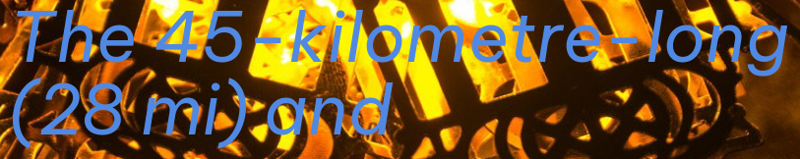

{'sample': 0, 'background': '/mnt/layered_data/inpainting_250k_subset_rendered/x4O6ZnBcvQmgcGa2Nf58', 'font': '/home/ubuntu/fonts_top_1000/Be Vietnam.ttf', 'font_size': 70, 'text': 'The 45-kilometre-long (28 mi) and', 'bbox': (139, 228, 936, 374), 'chosen_width': 0}
0


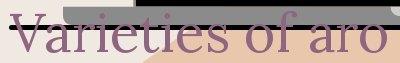

{'sample': 1, 'background': '/mnt/layered_data/inpainting_250k_subset_rendered/uQ8J9cHGtZSB8YDkAAf7', 'font': '/home/ubuntu/fonts_top_1000/Lora.ttf', 'font_size': 54, 'text': 'Varieties of aro', 'bbox': (107, 521, 491, 568), 'chosen_width': 0}


In [30]:
# Random sampling visualization (original + crop pairs)
num_samples = 2
padding = 8
wiki_ratio = 0.5
max_chars = 200

for i in range(num_samples):
    bg_img, bg_meta = random_text_free_background(RENDERED_ROOT, JSON_ROOT)
    text = get_random_text(
        length_pool=TEXT_LENGTH_POOL,
        lang="en",
        json_text_pool=TEXT_CONTENT_POOL,
        wiki_ratio=wiki_ratio,
        max_chars=max_chars,
    )
    font_size = random.randint(32, 72)
    width_candidates = [0, 1, 2]
    width_weights = [20, 2, 1]
    chosen_width = random.choices(width_candidates, weights=width_weights, k=1)[0]
    print(chosen_width)
    img, meta = make_augmented_image(
        bg_img,
        text,
        font_size=font_size,
        stroke_width=chosen_width,
        background_info=bg_meta.get("sample_dir", ""),
        families=FONT_FAMILIES,
    )
    meta.update(bg_meta)

    orig = img.copy()
    if max(orig.size) > 800:
        orig.thumbnail((800, 800))
    #display(orig)

    crop = crop_bbox(img, meta["bbox"], padding=padding)
    if max(crop.size) > 800:
        crop.thumbnail((800, 800))
    display(crop)

    print({
        "sample": i,
        "background": meta.get("background"),
        "font": meta.get("font"),
        "font_size": meta.get("font_size"),
        "text": meta.get("text"),
        "bbox": meta.get("bbox"),
        "chosen_width": chosen_width,
    })
